In [552]:
using StatsBase
using LinearAlgebra
using Plots
using Random

In [906]:
#Define the parameters n, L(n), t, Ne(L)

n = 7
L = 8*n + 4
t = 1
Ne = Int(L / 2)

30

In [907]:
#Here we define the hamiltonian and the states - Lstate (length L with +1 -1 0 and 2 as occupancies)
#as well as the conversion between states from L to the extended one of 2L and viceversa

function Hamiltonian(L,t)
    H = zeros(2*L, 2*L)
    H[1,L] = -t
    H[L,1] = -t
    H[2L,L+1] = -t
    H[L+1,2L] = -t
    for i=1:2*L
      for j=1:2*L
        if i == j + 1 || i == j - 1
          H[i,j] = -t
        end 
      end
    end
    H[L,L+1]=0
    H[L+1,L]=0
    return H
end

H = Hamiltonian(L,t);


#generate, convert state
function Lstate(L)                                 #generate a state of length L
    Lstated, Lstateu, Lstate = zeros(L), zeros(L), zeros(L)
    randomposu = sample(collect(1:L), Int(L/4), replace=false)
    randomposd = sample(collect(1:L), Int(L/4), replace=false)
    for j in randomposu
        Lstateu[j] = 1
    end
    for j in randomposd
        Lstated[j] = -1
    end
    for i=1:L 
        if Lstated[i] == -1 && Lstateu[i] == 1
            Lstate[i] = 2
        else
            Lstate[i] = Lstated[i] + Lstateu[i]
        end
    end
    return Lstate
end


function extendedstate(Lstatevector)               #take a state of length L and make it 2*L
    L = length(Lstatevector)
    State2L = zeros(2*L)
    for j=1:L
        if Lstatevector[j] == -1
            State2L[j + L] = 1
        elseif Lstatevector[j] == 1
            State2L[j] = 1
        elseif Lstatevector[j] == 2
            State2L[j], State2L[j + L] = 1,1
        else
            State2L[j] = 0
        end
    end
    return State2L
end


function shortstate(ext_state)                    #pass trom 2*L state to L state
    L = Int(length(ext_state)/2)
    sh_state = zeros(L)
    for j=1:L
        if ext_state[j]==1
            sh_state[j]=1
        end
    end
    for j=1:L
        if ext_state[L+j]==1
            if sh_state[j]==1
                sh_state[j]=2
            else
                sh_state[j]=-1
            end
        end
    end
    return sh_state
end

shortstate (generic function with 1 method)

In [908]:
#In this section we define functions to found the occupied and empty sites in our state and the move - hopping functions
#There are 3 options for the move, move_L and hopping makes a hop in vectors of length L and move_last_2L with ones  

#generate a move
function Pauli(x,i,j)                 #check if state i and j are both occupied
    if x[i] == 1 && x[j] == 1
        return true
    end
    return false
end 

function occupied_states(v)         #generate a vector with positions of occupied states (from 2*L states)
    occ_states = []
    L = length(v)
    for i = 1:L
        if v[i] == 1
            append!(occ_states, i)
        end
    end
    return occ_states
end


function occupied_states_L(v)
    occ_states = []
    L =length(v)
    for i = 1 : L
        if abs(v[i]) == 1
            append!(occ_states, i )
            
        elseif v[i] == 2
            append!(occ_states, i )
        
        end
    end
    return occ_states
end

function empty_states(v)
    empty_st_u = []
    empty_st_d = []
    L = length(v)
    for i = 1 : Int(L/2)
        if v[i] == 0
               append!(empty_st_u, i )
        end
    end
    for i = Int(L/2)+1 : L
        if v[i] == 0
               append!(empty_st_d, i )
        end
    end
    return empty_st_u, empty_st_d
end

function move_L(w)
    
   v = copy(w)
   i = rand(occupied_states_L(v))
   j = rand(-1:2:1)

    j_pbc = mod(i+j,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc

    if v[i] != v[j_pbc] && v[j_pbc]!=2

        if abs(v[i])==1
            v[j_pbc] == 0 ? v[j_pbc] = v[i] : v[j_pbc] = 2
            v[i] = 0

        elseif v[i]==2    
            spin = rand(-1:2:1)

        if v[j_pbc] != spin
           v[i] = -spin

        if abs(v[j_pbc]) == 1 
            v[j_pbc] = 2 
        elseif v[j_pbc] == 0 
            v[j_pbc] = spin 
        end

        end    
        end
            
    end

    return v
    
end

function move_last_2L(w)
    v = copy(w)
    L = length(v)
    i = rand(occupied_states(v))
    if i < L+1 
        j = rand(empty_states(v)[1])
        v[j] = v[i]
    else 
        j = rand(empty_states(v)[2])
    end
    v[i] = 0
    b = shortstate(v)
    return b
end

function hopping(v)
    w = copy(v)
    occupied_positions = occupied_states_L(v)
    i = rand(occupied_positions)
    nn = [v[i + 1],v[i - 1]]
    nnpos = [i + 1, i - 1]
    rndnnpos = rand([i + 1,i - 1])
    rndnn = rand(nn)
    
    if nn[1] == 2 && nn[2] == 2 || v[i] == 1 && nn[1] == 1 && nn[2] == 2 || v[i] == 1 && nn[1] == 2 && nn[2] == 1 || v[i] == 1 && nn[1] == 1 && nn[2] == 1 || v[i] == -1 && nn[1] == -1 && nn[2] == 2 || v[i] == -1 && nn[1] == 2 && nn[2] == -1 || v[i] == -1 && nn[1] == -1 && nn[2] == -1
        i = rand(deleteat!(occupied_positions, findall(x->x==i,occupied_positions)))
    end
    
    if v[i] == 1 && v[rndnnpos] == 1 || v[i] == 1 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
    
    if v[i] == -1 && v[rndnnpos] == -1 || v[i] == -1 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
    
    if v[i] == 2 && v[rndnnpos] == 2
        rndnnpos = rand(deleteat!(nnpos, findall(x->x==rndnnpos, nnpos)))
    end
     
    if v[i] == 1
        if v[rndnnpos] == -1
            w[i], w[rndnnpos] = 0, 2
        elseif v[rndnnpos] == 0
            w[i], w[rndnnpos] = 0, 1
        end
    
    elseif v[i] == -1 
        if v[rndnnpos] == 1
            w[i], w[rndnnpos] = 0, 2
        elseif v[rndnnpos] == 0
            w[i], w[rndnnpos] = 0, -1
        end
    
    elseif v[i] == 2
        if v[rndnnpos] == 1 
            w[i], w[rndnnpos] = 1, 2
        elseif v[rndnnpos] == -1
            w[i], w[rndnnpos] = -1,2
        elseif v[rndnnpos] == 0
            choosenspin = rand([1,-1])
            w[i], w[rndnnpos] = -1*choosenspin, choosenspin
        end
    end
    
    return w
end

hopping (generic function with 1 method)

In [909]:
#generate unitary matrices and the ratio of determinants

U = eigvecs(H)  #unitary matrix
Udag = inv(U)   #U^-1
E = eigvals(H)  #eigenvalues of H

function U1(A, Ne) #take the first Ne columns
    U_1 = A[:,1:Ne]
    return U_1
end

U_1 = U1(U,Ne)

function U_tilde(A,v)                  #takes just the rows related to occupied states, Ne*Ne matrix
    U_tild = []
    U_tild = A[occupied_states(v),:]
    return U_tild
end

function ratio_det(v, z)
    rat= det(U_tilde(U_1,z))/det(U_tilde(U_1,v))
    return rat
end  


ratio_det (generic function with 1 method)

In [910]:
#Jastrow factor
function n_i(vi)           #counts the number of els in positions vi, returning (# up , # down)
    
    n_up = 0
    n_down = 0
    
        if vi == 1
            n_up += 1
            
        elseif vi == -1
            n_down += 1
                
        elseif vi == 2
            n_down += 1
            n_up += 1
                
        end

return n_up, n_down

end

function Jastrow(state,g,v)
            
    D=length(state)       
    
    Spins=0
    Occupancies=0  
    
   # n1 = n_i(state[D])[1] + n_i(state[D])[2]
    n2 = 0
    
    for i = 1 : D     
            
    j_pbc = mod(L+i+1,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc
                
        n_up= n_i(state[i])[1]    
        n_down = n_i(state[i])[2]
                
    Spins = Spins + n_up*n_down 
                
    n1= n_up + n_down
        
    n_up= n_i(state[j_pbc])[1]    
    n_down = n_i(state[j_pbc])[2]
    
     n2= n_up + n_down
        
    n1n2 = n1*n2   
    n1 = n2
                
    Occupancies = Occupancies + n1n2
            
        end
    
    arg=  -g*Spins -v*Occupancies
            
return exp(arg), arg

end
#This function calculates the density observable in the odd sites A
function nA(v)
    nA = 0
    for j=1:length(v)
        if j%2 != 0
            nA += sum(n_i(v[j])) 
        end
    end
    return nA*2/length(v)
end

#This function calculates the density observable in the even sites B
function nB(v)
    nB = 0
    for j=1:length(v)
        if j%2 == 0
            nB += sum(n_i(v[j])) 
        end
    end
    return nB*2/length(v)
end

nB (generic function with 1 method)

In [911]:
function Jastrow(state,g,v)
            
    L=length(state)       
    
    Spins=0
    Occupancies=0  
    
   # n1 = n_i(state[D])[1] + n_i(state[D])[2]
    n2 = 0
    
    for i = 1 : L    
            
    j_pbc = mod(L+i+1,L)
    j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc
                
        n_up= n_i(state[i])[1]    
        n_down = n_i(state[i])[2]
                
    Spins = Spins + n_up*n_down 
                
    n1= n_up + n_down
        
    n_up= n_i(state[j_pbc])[1]    
    n_down = n_i(state[j_pbc])[2]
    
     n2= n_up + n_down
        
    n1n2 = n1*n2   
    n1 = n2
                
    Occupancies = Occupancies + n1n2
            
        end
    
    arg=  -g*Spins -v*Occupancies
            
return exp(arg)
    
end

Jastrow (generic function with 1 method)

In [912]:
v = [1 0 0 0 2 0 1 0 -1 0]

Jastrow(v,100,2)

3.720075976020836e-44

In [913]:
exp(Jastrow(v,100,2))

1.0

In [914]:
v = Lstate(12)

Jastrow(v,100,2)

6.813556821545298e-46

In [915]:
log(8.25211544181389e112)

260.0

In [916]:
#Block analysis
function Block(v, Ne, Ni)
    
    Average_Bin = []
    
    N=length(v)
    
    Lbin = Ne
    
    Nbin = floor(Int,N/Lbin)
    
    a=0
    b=0
    
    for i in Ni:Nbin
       
    a = (i-1)*Lbin +1
    b = i*Lbin
        
av_bin = (1/Int(abs(Lbin)))*(sum(v[Int64(a):Int64(b)]))
        
push!(Average_Bin,av_bin)
        
    end

return Average_Bin, sum(Average_Bin)/(Nbin-Ni+1), Nbin

end

Block (generic function with 1 method)

In [917]:
#Block analysis
function Block(v, Ne, Ni)
    
    Average_Bin = []
    
    N=length(v)
    
    Lbin = Ne
    
    Nbin = floor(Int,N/Lbin)
    
    a=0
    b=0
    
    for i in Ni:Nbin
       
    a = (i-1)*Lbin +1
    b = i*Lbin
        
av_bin = (1/Int(abs(Lbin)))*(sum(v[Int64(a):Int64(b)]))
        
push!(Average_Bin,av_bin)
        
    end

return Average_Bin, sum(Average_Bin)/(Nbin-Ni+1), Nbin

end

Block (generic function with 1 method)

In [918]:
f = Figure()
Axis(f[1, 1])

x = collect(1:10)
y = [MC_pietro(a,10,v,30,5,100)[1] for v in x]

lowerrors = [-MC_pietro(a,10,v,30,5,100)[2] for v in x]
higherrors = [MC_pietro(a,10,v,30,5,100)[2] for v in x]

errorbars!(x, y, higherrors, color = :red) 

errorbars!(x, y, lowerrors, color = :red) # same low and high error
# plot position scatters so low and high errors can be discriminated
scatter!(x, y, markersize = 3, color = :black)

f


LoadError: [91mUndefVarError: Figure not defined[39m

In [919]:
function Error_Block(v, Ne, Ni)
    
    SD_Array = []

    Average_Bin, ave, Nbin = Block(v, Ne, Ni)
    
    for i in 1:length(Average_Bin)

    av_bin = Average_Bin[i] - ave
        
     push!(SD_Array,av_bin^2 )
        
    end

return sqrt(mean(SD_Array))/sqrt(Nbin)
    
end

Error_Block (generic function with 1 method)

In [920]:
function orthogonal(w, i)
    v = copy(w)
    L = length(v)
    states = []
    J = [-1,1]
    
    for j in J
        
        v = copy(w)
    
        j_pbc = mod(i+j,L)
        j_pbc == 0 ? j_pbc = L : j_pbc = j_pbc

            if v[i] != v[j_pbc] && v[j_pbc]!=2

                if abs(v[i])==1
                v[j_pbc] == 0 ? v[j_pbc] = v[i] : v[j_pbc] = 2 
                v[i] = 0    
                push!(states,v)

                elseif v[i]==2    
                Spin = [-1,1]

                    for spin in Spin
                    v = copy(w)

                            if spin != v[j_pbc] && v[j_pbc]!=2
                                v[j_pbc] == 0 ? v[j_pbc] = spin : v[j_pbc] = 2 
                                v[i] = -spin
                                push!(states,v)
                            end  
                      end
                 end   
          end
        
    end 
    
    return states
    
end

orthogonal (generic function with 1 method)

In [921]:

function MC_pietro(q0, g, v, U,V, nsteps = 1000)
    
    t=1
    #Random.seed!(1234)
    local_est = 0
    state_L = copy(q0)
    local_est_array = []
    locals = []
    
    state_new_L = 0
    state_new_2L = 0
    
    x_prime_L = []
    x_prime_2L = []
    sumA=0
    sumB=0
    accepted_moves = 0
    state_new_L = zeros()
    x_L = zeros()
    x_2L = zeros()
    
    Suma_A = []
    Suma_B = []
    
    Pot= []
    
    EN = []
    
    k=0
    l=0
    
   
    for istep = 1:nsteps

        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = move_L(state_L)
            state_new_2L = extendedstate(state_new_L)

            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2
            
            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                state_L = copy(state_new_L)
                state_2L = copy(state_new_2L)
                accepted_moves += 1
            end
        end
        x_L = copy(state_new_L)
        x_2L = copy(state_new_2L)
        pot = log(Jastrow(x_L,-U,-V))
        #display(pot)
        
              e_n = 0
        
                 for i in occupied_states_L(x_L)
        
                 o_states = orthogonal(x_L, i)
            
                     for j in 1:length(o_states)
                        x_prime_L = o_states[j]
                        x_prime_2L = extendedstate(x_prime_L)   
                         Prob =  (ratio_det(x_2L,x_prime_2L)*((Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))))^2
                         acc = min(1,Prob)

                           if Prob<=1 && Prob>rand()   
                           local_est = -t*ratio_det(x_2L,x_prime_2L)*(Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))
      
                           end
                
                             e_n += local_est
                                              
                     end      
                 end
   
           push!(EN,e_n)
        
           e_n += pot 
        
           push!(locals,e_n)
            
           push!(Pot,pot)
        
          end
    
    return  Block(locals,floor(Int,Ne/2),1)[2]
end

MC_pietro (generic function with 4 methods)

In [925]:
#=
#Monte Carlo simulation that calculates nA along the simulation
import Random

function MC_pietro(q0, g, v, U,V, nsteps = 1000)
    #Random.seed!(1234)
    local_est = 0
    state_L = copy(q0)
    local_est_array = []
    locals = []
    x_prime_L = []
    x_prime_2L = []
    sumA=0
    sumB=0
    accepted_moves = 0
    state_new_L = zeros()
    x_L = zeros()
    x_2L = zeros()
    
    Suma_A = []
    Suma_B = []
    
    for istep = 1:nsteps
        
        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = move_L(state_L)
            state_new_2L = extendedstate(state_new_L)
            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2       #acceptance 
            display((Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))
            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                x_L = copy(state_new_L)
                #display(x_L)
                x_2L = copy(state_new_2L)
                accepted_moves += 1
            end
        end
        
        #compute observables
        e_n = 0
        pot = log(Jastrow(x_L,-U,-V))            #x = x'
             #display(pot)
            
             for i in occupied_states_L(x_L)        # x' hopping neighbour of x
                 o_states = orthogonal(x_L, i)

                 for j in 1:length(o_states)
                        x_prime_L = copy(o_states[j])
                        x_prime_2L = extendedstate(x_prime_L)        

                        local_est = -t*ratio_det(x_2L,x_prime_2L)*(Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))
                        #display(local_est)
                        e_n += local_est
                 end
                    
            end
            
            #display(e_n)
        e_n += pot
            
        push!(locals,e_n)
    end
    return mean(locals)
end 

a = Lstate(L);
#MC_prova= MC_pietro(a,10,5,30,5,100)
=#
#Monte Carlo simulation that calculates nA along the simulation
#Monte Carlo simulation that calculates nA along the simulation
import Random

function MC_pietro(q0, g, v, U,V, nsteps = 1000)
    
    t=1
    #Random.seed!(1234)
    local_est = 0
    state_L = copy(q0)
    local_est_array = []
    locals = []
    
    state_new_L = 0
    state_new_2L = 0
    
    x_prime_L = []
    x_prime_2L = []
    sumA=0
    sumB=0
    accepted_moves = 0
    state_new_L = zeros()
    x_L = zeros()
    x_2L = zeros()
    
    Suma_A = []
    Suma_B = []
    
    Pot= []
    
    EN = []
    
    k=0
    l=0
    
    for istep = 1:nsteps

        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = move_L(state_L)
            state_new_2L = extendedstate(state_new_L)

            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2
            
            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                state_L = copy(state_new_L)
                state_2L = copy(state_new_2L)
                accepted_moves += 1
            end
        end
          
        x_L = copy(state_new_L)
        x_2L = copy(state_new_2L)
        pot = log(Jastrow(x_L,-U,-V))

        
        e_n = 0
        
              for i in occupied_states_L(x_L)
        
                 o_states = orthogonal(x_L, i)
            
                     for j in 1:length(o_states)
                        x_prime_L = o_states[j]
                        x_prime_2L = extendedstate(x_prime_L)   
                        Prob =  (ratio_det(x_2L,x_prime_2L)*((Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))))^2
                        acc = min(1,Prob)

                           if Prob<=1 
                           local_est = -t
                         
                           #local_est = -t*ratio_det(x_2L,x_prime_2L)*(Jastrow(x_prime_L,g,v)/Jastrow(x_L,g,v))
                           #local_est = -t*ratio_det(x_2L,x_prime_2L)
                           e_n += local_est
                           end 
                           
                     end      
                 end
                     #  display(e_n)
           push!(EN,e_n)
        
           e_n += pot 
        
           push!(locals,e_n)
            
           push!(Pot,pot)
          end
    

    return  Block(locals,Int64(Ne/2),Int64(1))[2] #, Error_Block(locals,Int64(Ne/2),Int64(1))
end

MC_pietro (generic function with 4 methods)

In [926]:
a = Lstate(L);
MC_pietro(a,10,8,30,5,100)

-1.9555555555555557

In [186]:
ENV["GKS_ENCODING"]="utf-8"
using Plots
gr()

Plots.GRBackend()

In [887]:
using Plots
x = collect(0:10:100)
PAUL1 = [MC_pietro(a,10,v,0.3,0.1,100) for v in x]


11-element Array{Tuple{Float64,Float64},1}:
 (-7.208369065421426, 0.3911315971168521)
 (-2.6446183163364956, 0.15117041464907077)
 (-0.03124251372594267, 0.17562710033507173)
 (-0.8632538624737139, 0.14985343719307936)
 (-0.9791964842486127, 0.16731063466957052)
 (-1.3458139740677921, 0.18709029507443212)
 (-1.6293174442839347, 0.26876251954390523)
 (1.9477777777777778, 0.011267419070500889)
 (1.9566666666666668, 0.008425417160057267)
 (1.9533333333333334, 0.007370277311900902)
 (1.9344444444444442, 0.006366708680618913)

In [888]:
x = collect(0:10:100)
PAUL2 = [MC_pietro(a,10,v,0.30,0.1,100) for v in x]

11-element Array{Tuple{Float64,Float64},1}:
 (-7.237841996270501, 0.3794990724320207)
 (-2.817600223819886, 0.2534204678259377)
 (-0.6326735700942724, 0.1236689830485148)
 (-0.9590368172806976, 0.19147636706433407)
 (-1.4311186192656502, 0.13183010816731192)
 (-1.8984595845303154, 0.20359566159296014)
 (-0.529071620381587, 0.17383851005495995)
 (1.9588888888888885, 0.015588589263507379)
 (1.9366666666666663, 0.010858233492051103)
 (1.9533333333333331, 0.008748897637790921)
 (1.941111111111111, 0.006366708680618888)

In [729]:
x = collect(0:5:125)
A3 = [MC_pietro(a,10,v,30,0,100) for v in x]

26-element Array{Tuple{Float64,Float64},1}:
 (1.8580437116335542, 1.2859491386351787)
 (6.586256692644103, 4.015098264569871)
 (30.95505028382956, 10.446671710554064)
 (139.04154380054774, 2.060184951580873)
 (137.94258450997475, 1.9248594414412248)
 (196.1412900033131, 1.9745838981961672)
 (225.78879429137586, 1.088095622130398)
 (194.97210335006676, 1.898951974150986)
 (225.27026057923942, 2.716636689583985)
 (196.5175015585257, 1.9428013921276484)
 (166.7240679302729, 2.463934334907312)
 (223.69381159591157, 1.5324422440093448)
 (140.46888583832308, 1.2135454397879128)
 (192.9124957223436, 4.933605803769689)
 (66.0, 1.2472191289246473)
 (67.0, 1.7480147469502527)
 (66.0, 1.2472191289246473)
 (65.66666666666667, 1.2838022231434827)
 (64.0, 0.6666666666666667)
 (62.0, 1.0540925533894598)
 (64.66666666666667, 1.5396007178390023)
 (65.66666666666667, 1.097134314340639)
 (67.33333333333333, 1.742709682373125)
 (64.33333333333333, 1.5214515486254616)
 (66.0, 0.6666666666666667)
 (65.0, 1.

In [836]:
x = collect(0:5:125)
A5 = [MC_pietro(a,10,v,30,25,100) for v in x]

26-element Array{Tuple{Float64,Float64},1}:
 (288.79322104577244, 9.42312779552322)
 (68.23129134545012, 10.86741615849503)
 (86.80531084827702, 16.686456698366467)
 (252.70693989518062, 2.7262631692619386)
 (275.0937143744905, 2.21914626471067)
 (205.39379505506474, 5.051445330662907)
 (247.70552279082744, 1.3960681221616658)
 (198.61121945886416, 1.3538251168493682)
 (185.79406092680188, 1.2739257248246068)
 (218.37954738822438, 1.7113271467155082)
 (230.14094313462473, 2.758522988613237)
 (202.3841518453593, 1.6486525953370117)
 (277.10528736871737, 1.1852781446128344)
 (225.64880083768955, 4.001869188651264)
 (389.5555555555556, 1.4837944906674128)
 (388.27777777777777, 2.147948585877239)
 (387.1666666666667, 1.9384829247075421)
 (382.5, 0.6792788478131941)
 (386.4444444444444, 1.773722225992397)
 (387.0, 1.4969103983674978)
 (387.4444444444445, 1.6734430144566468)
 (390.9444444444445, 2.5183483057949765)
 (389.8333333333333, 1.4587962228334324)
 (383.0, 2.138708506102238)
 (388.44

In [826]:
x = collect(0:25:125)
A5 = [MC_pietro(a,10,v,40,30,100) for v in x]

6-element Array{Tuple{Float64,Float64},1}:
 (360.05205561483893, 10.789159359183692)
 (221.93050828017655, 2.3728949023637336)
 (314.1708731692473, 1.6885116117228198)
 (471.6666666666667, 1.7409377351102673)
 (473.4444444444444, 1.2513367338167516)
 (475.77777777777777, 2.0528009571186683)

In [666]:
x = collect(0:1:8)
A8 = [MC_pietro(a,v,2,30,5,100) for v in x]

9-element Array{Tuple{Float64,Float64},1}:
 (228.02288863601143, 4.670649187145933)
 (127.41756651514741, 3.797091434483427)
 (87.41569894137363, 6.70264560003261)
 (39.94928876198416, 5.627860817740902)
 (26.034944428563353, 9.011758620417913)
 (20.45467353232124, 2.9751333667406277)
 (18.465990437734636, 4.260515301591188)
 (22.658261369202876, 2.0779180390780434)
 (26.657898101335558, 2.292815563840076)

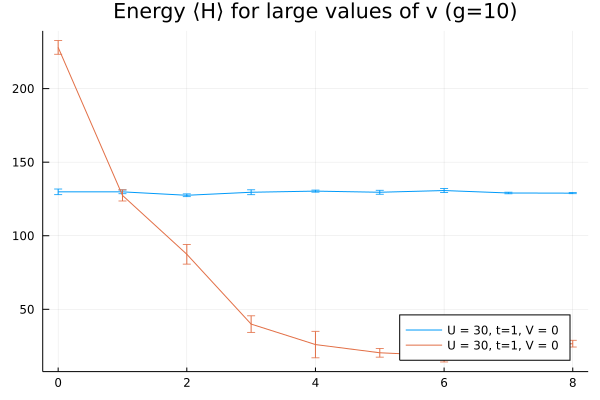

In [788]:
averages_5 = []
averages_15 = []
error_5 = []
error_15 = []

error_0 = []
averages_0  = []

error_10 = []
averages_10  = []

x = collect(0:1:8)


for i in 1:length(x)
    push!(averages_5, A6[i][1])
    push!(error_5, A6[i][2])
    
        push!(averages_15, A8[i][1])
    push!(error_15, A8[i][2])
    
end

p_6 = plot(x,averages_5, title = "Energy ⟨Η⟩ for large values of v (g=10)", label = "U = 30, t=1, V = 0", yerror = error_5, markerstrokecolor=:auto, legend=:bottomright )
      plot!(x,averages_15, title = "Energy ⟨Η⟩ for large values of v (g=10)", label = "U = 30, t=1, V = 0", yerror = error_15, markerstrokecolor=:auto, legend=:bottomright )


In [883]:
averages_5 = []
averages_15 = []
error_5 = []
error_15 = []

error_0 = []
averages_0  = []

error_10 = []
averages_10  = []

x = collect(0:10:100)

for i in 1:length(x)
    push!(averages_5, PAUL1[i][1])
    push!(averages_15,PAUL2[i][1])
    push!(averages_0, A3[i][1])
     push!(averages_10, A5[i][1])
    push!(error_5, PAUL1[i][2])
    push!(error_15, PAUL2[i][2])
    push!(error_0, A3[i][2])
    push!(error_10, A5[i][2])
    
end

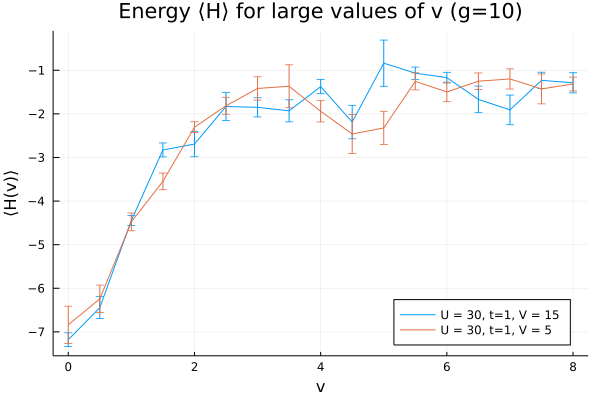

In [886]:
x = collect(0:0.5:8)

p_6 = plot(x,averages_15, title = "Energy ⟨Η⟩ for large values of v (g=10)", label = "U = 30, t=1, V = 15", yerror = error_15, markerstrokecolor=:auto, legend=:bottomright )
 plot!(x,averages_5, label = "U = 30, t=1, V = 5", yerror = error_5, markerstrokecolor=:auto )
# plot!(x,averages_0, label = "U = 30, t=1, V = 0", yerror = error_0, markerstrokecolor=:auto )
#plot!(x,averages_10, label = "U = 30, t=1, V = 25", yerror = error_10, markerstrokecolor=:auto )



#plot!(x,averages_51, title = "Energy ⟨Η⟩ as a function of υ (g=10)", label = "U = 30, t=1, V = 5", yerror = error_51, markerstrokecolor=:auto, legend=:topleft )
 #     plot!(x,averages_151, title = "Energy ⟨Η⟩ as a function of υ (g=10)", label = "U = 30, t=1, V = 15", yerror = error_151, markerstrokecolor=:auto )       

xlabel!(p_6, "v")
ylabel!(p_6, "⟨Η(v)⟩")
#savefig("Q2-Negatives.png")
       

In [676]:
averages_51 = []
averages_151 = []
error_51 = []
error_151 = []

x = collect(0:12)

for i in 1:length(x)
    push!(averages_51, y[i][1])
    push!(averages_151, y2[i][1])
    push!(error_51, y[i][2])
    push!(error_151, y2[i][2])
    
end

In [436]:
averages_5 = []
averages_15 = []
error_5 = []
error_15 = []

x = collect(0:5:25)

for i in 1:length(x)
    push!(averages_5, w21_[i][1])
    push!(averages_15, w1_[i][1])
    push!(error_5, w21_[i][2])
    push!(error_15, w1_[i][2])
    
end

In [589]:
using Plots
x = collect(0:2:24)
VV1 = [MC_pietro(a,10,100,30,v,100) for v in x]

100-element Array{Any,1}:
 60.0
 60.0
 30.0
 60.0
 60.0
 60.0
 60.0
 90.0
 60.0
 60.0
 90.0
 30.0
 60.0
  ⋮
 60.0
 60.0
 60.0
 90.0
 60.0
 60.0
 60.0
 60.0
 60.0
 60.0
 60.0
 60.0

100-element Array{Any,1}:
  88.0
  56.0
  84.0
  88.0
  86.0
  86.0
  86.0
  58.0
  84.0
  86.0
  86.0
  88.0
  84.0
   ⋮
  88.0
  90.0
  88.0
  58.0
  86.0
 116.0
  86.0
  86.0
 116.0
  86.0
  84.0
 116.0

100-element Array{Any,1}:
 108.0
 120.0
 108.0
 112.0
 142.0
 108.0
 138.0
 116.0
 112.0
 116.0
 108.0
 112.0
 134.0
   ⋮
 116.0
 134.0
 112.0
 116.0
 112.0
 142.0
 112.0
 112.0
 116.0
 112.0
 134.0
 142.0

100-element Array{Any,1}:
 138.0
 138.0
 150.0
 144.0
 168.0
 132.0
 132.0
 144.0
 138.0
 138.0
 156.0
 114.0
 132.0
   ⋮
 168.0
 150.0
 162.0
 168.0
 144.0
 138.0
 138.0
 138.0
 138.0
 144.0
 144.0
 156.0

100-element Array{Any,1}:
 156.0
 178.0
 194.0
 164.0
 164.0
 164.0
 164.0
 142.0
 156.0
 156.0
 156.0
 164.0
 142.0
   ⋮
 156.0
 172.0
 172.0
 186.0
 172.0
 172.0
 172.0
 156.0
 156.0
 172.0
 156.0
 186.0

100-element Array{Any,1}:
 190.0
 190.0
 180.0
 200.0
 190.0
 180.0
 180.0
 210.0
 180.0
 200.0
 220.0
 180.0
 210.0
   ⋮
 180.0
 190.0
 190.0
 200.0
 200.0
 210.0
 210.0
 200.0
 190.0
 190.0
 210.0
 200.0

100-element Array{Any,1}:
 228.0
 204.0
 204.0
 216.0
 228.0
 204.0
 216.0
 228.0
 216.0
 216.0
 204.0
 216.0
 228.0
   ⋮
 216.0
 222.0
 216.0
 228.0
 222.0
 216.0
 216.0
 216.0
 228.0
 216.0
 204.0
 216.0

100-element Array{Any,1}:
 242.0
 242.0
 256.0
 242.0
 228.0
 256.0
 272.0
 242.0
 242.0
 244.0
 242.0
 244.0
 256.0
   ⋮
 244.0
 272.0
 272.0
 256.0
 258.0
 256.0
 256.0
 242.0
 258.0
 242.0
 242.0
 242.0

100-element Array{Any,1}:
 284.0
 266.0
 284.0
 284.0
 282.0
 284.0
 284.0
 298.0
 268.0
 268.0
 266.0
 238.0
 252.0
   ⋮
 284.0
 252.0
 268.0
 284.0
 298.0
 298.0
 252.0
 282.0
 238.0
 268.0
 298.0
 268.0

100-element Array{Any,1}:
 294.0
 312.0
 294.0
 312.0
 264.0
 312.0
 312.0
 294.0
 312.0
 276.0
 294.0
 324.0
 306.0
   ⋮
 276.0
 294.0
 294.0
 294.0
 288.0
 294.0
 306.0
 276.0
 282.0
 324.0
 276.0
 276.0

100-element Array{Any,1}:
 320.0
 300.0
 350.0
 320.0
 340.0
 320.0
 320.0
 300.0
 320.0
 320.0
 340.0
 340.0
 320.0
   ⋮
 300.0
 300.0
 320.0
 340.0
 320.0
 320.0
 300.0
 320.0
 350.0
 320.0
 330.0
 340.0

100-element Array{Any,1}:
 346.0
 368.0
 354.0
 324.0
 316.0
 354.0
 346.0
 368.0
 332.0
 390.0
 332.0
 324.0
 368.0
   ⋮
 346.0
 346.0
 324.0
 324.0
 368.0
 354.0
 368.0
 354.0
 346.0
 376.0
 368.0
 332.0

100-element Array{Any,1}:
 396.0
 396.0
 372.0
 396.0
 396.0
 372.0
 372.0
 396.0
 378.0
 378.0
 348.0
 342.0
 372.0
   ⋮
 372.0
 354.0
 396.0
 402.0
 372.0
 348.0
 372.0
 372.0
 366.0
 372.0
 396.0
 348.0

13-element Array{Tuple{Float64,Float64},1}:
 (65.33333333333333, 1.6101529717988268)
 (90.02222222222223, 1.2936374849187202)
 (117.39999999999999, 1.3972636397660765)
 (144.46666666666667, 1.5475189222800527)
 (167.42222222222222, 1.2787596871377185)
 (193.33333333333334, 0.7856742013183857)
 (219.60000000000002, 1.2036980056845183)
 (245.46666666666667, 0.641756847919717)
 (272.55555555555554, 1.1406806140960228)
 (294.8, 1.4907119849998576)
 (323.77777777777777, 1.0501812502783536)
 (350.4444444444445, 1.249855958779037)
 (374.1333333333334, 1.1987647963787758)

In [590]:
x = collect(0:2:24)
VV2 = [MC_pietro(a,10,100,5,v,100) for v in x]

100-element Array{Any,1}:
 15.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 15.0
 10.0
 10.0
 10.0
  ⋮
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 10.0
 15.0
  5.0
 10.0
 10.0

100-element Array{Any,1}:
 34.0
 36.0
 39.0
 39.0
 38.0
 38.0
 36.0
 36.0
 39.0
 36.0
 36.0
 36.0
 37.0
  ⋮
 36.0
 36.0
 36.0
 36.0
 41.0
 34.0
 38.0
 41.0
 36.0
 41.0
 38.0
 38.0

100-element Array{Any,1}:
 63.0
 62.0
 66.0
 62.0
 62.0
 66.0
 66.0
 66.0
 62.0
 58.0
 58.0
 67.0
 66.0
  ⋮
 58.0
 62.0
 66.0
 62.0
 58.0
 67.0
 66.0
 62.0
 62.0
 62.0
 63.0
 57.0

100-element Array{Any,1}:
  94.0
  82.0
  94.0
  88.0
  82.0
  88.0
  81.0
  93.0
  88.0
  94.0
  88.0
  93.0
  94.0
   ⋮
  88.0
  93.0
  94.0
  88.0
 100.0
  88.0
  94.0
  94.0
  94.0
  81.0
  88.0
  88.0

100-element Array{Any,1}:
 122.0
 122.0
 111.0
 122.0
 122.0
 106.0
 111.0
 114.0
 122.0
 114.0
 106.0
 117.0
 117.0
   ⋮
 122.0
 103.0
 119.0
 119.0
 114.0
 109.0
 111.0
 114.0
 114.0
 122.0
 119.0
 106.0

100-element Array{Any,1}:
 150.0
 140.0
 140.0
 140.0
 145.0
 140.0
 150.0
 135.0
 130.0
 150.0
 150.0
 145.0
 135.0
   ⋮
 150.0
 130.0
 140.0
 130.0
 130.0
 130.0
 140.0
 130.0
 135.0
 150.0
 150.0
 140.0

100-element Array{Any,1}:
 166.0
 166.0
 166.0
 166.0
 166.0
 166.0
 147.0
 166.0
 166.0
 166.0
 190.0
 178.0
 159.0
   ⋮
 178.0
 166.0
 166.0
 178.0
 171.0
 178.0
 178.0
 154.0
 178.0
 166.0
 166.0
 154.0

100-element Array{Any,1}:
 169.0
 192.0
 178.0
 192.0
 206.0
 169.0
 192.0
 192.0
 201.0
 206.0
 192.0
 220.0
 220.0
   ⋮
 192.0
 192.0
 192.0
 183.0
 192.0
 169.0
 192.0
 192.0
 206.0
 192.0
 178.0
 220.0

100-element Array{Any,1}:
 234.0
 202.0
 234.0
 207.0
 218.0
 218.0
 229.0
 234.0
 207.0
 218.0
 223.0
 213.0
 191.0
   ⋮
 234.0
 207.0
 202.0
 202.0
 218.0
 218.0
 234.0
 234.0
 202.0
 191.0
 234.0
 202.0

100-element Array{Any,1}:
 231.0
 249.0
 244.0
 262.0
 244.0
 226.0
 249.0
 262.0
 226.0
 226.0
 262.0
 249.0
 244.0
   ⋮
 262.0
 226.0
 262.0
 249.0
 262.0
 244.0
 262.0
 262.0
 262.0
 226.0
 249.0
 262.0

100-element Array{Any,1}:
 290.0
 255.0
 250.0
 250.0
 290.0
 290.0
 270.0
 275.0
 270.0
 265.0
 235.0
 270.0
 270.0
   ⋮
 270.0
 270.0
 275.0
 255.0
 250.0
 250.0
 270.0
 275.0
 270.0
 270.0
 290.0
 270.0

100-element Array{Any,1}:
 296.0
 318.0
 296.0
 318.0
 296.0
 296.0
 318.0
 318.0
 296.0
 279.0
 291.0
 301.0
 296.0
   ⋮
 296.0
 296.0
 296.0
 296.0
 318.0
 279.0
 257.0
 296.0
 313.0
 296.0
 274.0
 274.0

100-element Array{Any,1}:
 327.0
 303.0
 322.0
 317.0
 346.0
 346.0
 298.0
 298.0
 317.0
 346.0
 322.0
 317.0
 303.0
   ⋮
 303.0
 298.0
 370.0
 346.0
 279.0
 346.0
 346.0
 322.0
 341.0
 346.0
 346.0
 322.0

13-element Array{Tuple{Float64,Float64},1}:
 (11.0, 0.260578653323524)
 (36.72222222222222, 0.09611806868415455)
 (62.788888888888884, 0.3052692261128245)
 (88.58888888888889, 0.195894067283081)
 (114.65555555555555, 0.7035038702617434)
 (139.16666666666666, 0.6223710139557811)
 (165.93333333333334, 0.44610799777521515)
 (193.43333333333337, 1.0937250878997113)
 (218.93333333333337, 1.1104442443243556)
 (242.25555555555556, 0.5892905688076105)
 (271.77777777777777, 0.989658460436102)
 (296.32222222222225, 1.828067634339654)
 (318.9555555555556, 2.157597352948077)

In [594]:
x = collect(0:2:24)
VV3= [MC_pietro(a,10,100,0,v,100) for v in x]

100-element Array{Any,1}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

100-element Array{Any,1}:
 26.0
 28.0
 26.0
 26.0
 26.0
 24.0
 28.0
 28.0
 26.0
 26.0
 24.0
 30.0
 26.0
  ⋮
 24.0
 24.0
 26.0
 24.0
 26.0
 24.0
 26.0
 28.0
 26.0
 26.0
 28.0
 24.0

100-element Array{Any,1}:
 56.0
 52.0
 48.0
 48.0
 52.0
 44.0
 52.0
 48.0
 56.0
 52.0
 52.0
 52.0
 52.0
  ⋮
 48.0
 52.0
 56.0
 52.0
 52.0
 52.0
 56.0
 48.0
 52.0
 56.0
 52.0
 52.0

100-element Array{Any,1}:
 78.0
 78.0
 78.0
 78.0
 72.0
 78.0
 66.0
 72.0
 78.0
 78.0
 84.0
 78.0
 78.0
  ⋮
 78.0
 72.0
 78.0
 78.0
 78.0
 66.0
 72.0
 78.0
 84.0
 84.0
 84.0
 78.0

100-element Array{Any,1}:
 104.0
 104.0
 104.0
 104.0
 104.0
 104.0
 104.0
 112.0
 104.0
 104.0
  96.0
 112.0
  96.0
   ⋮
 104.0
  88.0
 120.0
 104.0
  96.0
 112.0
 104.0
 112.0
  96.0
  96.0
 104.0
 104.0

100-element Array{Any,1}:
 140.0
 130.0
 120.0
 140.0
 140.0
 130.0
 120.0
 140.0
 120.0
 130.0
 130.0
 120.0
 130.0
   ⋮
 120.0
 130.0
 140.0
 140.0
 140.0
 140.0
 130.0
 120.0
 140.0
 120.0
 140.0
 130.0

100-element Array{Any,1}:
 168.0
 156.0
 144.0
 156.0
 156.0
 168.0
 156.0
 168.0
 156.0
 156.0
 156.0
 144.0
 156.0
   ⋮
 168.0
 156.0
 168.0
 156.0
 168.0
 168.0
 144.0
 168.0
 180.0
 156.0
 156.0
 168.0

100-element Array{Any,1}:
 182.0
 168.0
 196.0
 168.0
 154.0
 168.0
 168.0
 182.0
 182.0
 196.0
 182.0
 168.0
 154.0
   ⋮
 196.0
 168.0
 182.0
 182.0
 154.0
 168.0
 196.0
 168.0
 196.0
 154.0
 182.0
 196.0

100-element Array{Any,1}:
 208.0
 176.0
 224.0
 192.0
 192.0
 224.0
 208.0
 208.0
 192.0
 208.0
 224.0
 224.0
 224.0
   ⋮
 240.0
 224.0
 192.0
 192.0
 208.0
 208.0
 208.0
 224.0
 208.0
 224.0
 208.0
 224.0

100-element Array{Any,1}:
 216.0
 216.0
 234.0
 234.0
 252.0
 216.0
 252.0
 216.0
 252.0
 216.0
 234.0
 198.0
 252.0
   ⋮
 234.0
 216.0
 252.0
 234.0
 234.0
 234.0
 234.0
 234.0
 216.0
 234.0
 252.0
 216.0

100-element Array{Any,1}:
 260.0
 240.0
 240.0
 260.0
 260.0
 300.0
 260.0
 260.0
 240.0
 260.0
 220.0
 260.0
 260.0
   ⋮
 280.0
 280.0
 220.0
 260.0
 260.0
 260.0
 260.0
 260.0
 260.0
 260.0
 240.0
 220.0

100-element Array{Any,1}:
 308.0
 286.0
 286.0
 242.0
 286.0
 264.0
 264.0
 308.0
 264.0
 308.0
 242.0
 286.0
 308.0
   ⋮
 264.0
 330.0
 286.0
 242.0
 286.0
 308.0
 308.0
 286.0
 286.0
 264.0
 308.0
 264.0

100-element Array{Any,1}:
 288.0
 336.0
 288.0
 312.0
 336.0
 336.0
 288.0
 312.0
 312.0
 312.0
 312.0
 312.0
 336.0
   ⋮
 336.0
 312.0
 336.0
 312.0
 312.0
 288.0
 336.0
 312.0
 264.0
 264.0
 336.0
 288.0

13-element Array{Tuple{Float64,Float64},1}:
 (0.0, 0.0)
 (26.022222222222222, 0.20467780562441631)
 (51.33333333333332, 0.33701668640229104)
 (76.4, 0.5333333333333338)
 (103.11111111111113, 0.6846945190098571)
 (128.66666666666669, 0.8606629658238711)
 (155.33333333333334, 0.9506333171647743)
 (181.37777777777777, 1.611583583339858)
 (207.64444444444442, 1.2983053214937263)
 (231.0, 1.4628738838327797)
 (261.55555555555554, 2.2534838141001887)
 (283.3111111111111, 1.1157311356586703)
 (312.0, 1.3063945294843649)

In [614]:
averages_5 = []
averages_30 = []
error_5 = []
error_30 = []

averages_0 = []
error_0 = []

x = collect(0:2:24)

for i in 1:length(x)
    push!(averages_30, VV1[i][1])
    push!(averages_5, VV2[i][1])
    push!(error_30, VV1[i][2])
    push!(error_5, VV2[i][2])
    push!(averages_0, VV3[i][1])
    push!(error_0, VV3[i][2])
    
end

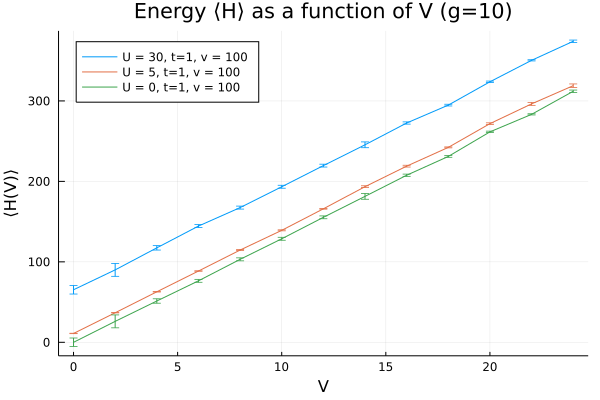

In [615]:
x = collect(0:2:24)
p_6 = plot(x,averages_30, title = "Energy ⟨Η⟩ as a function of V (g=10)", label = "U = 30, t=1, v = 100", yerror = error_15, markerstrokecolor=:auto )

plot!(x,averages_5, title = "Energy ⟨Η⟩ as a function of V (g=10)", label = "U = 5, t=1, v = 100", yerror = error_5, markerstrokecolor=:auto, legend=:topleft )
    
plot!(x,averages_0, title = "Energy ⟨Η⟩ as a function of V (g=10)", label = "U = 0, t=1, v = 100", yerror = error_15, markerstrokecolor=:auto )
       
        xlabel!(p_6, "V")
        ylabel!(p_6, "⟨Η(V)⟩")
#savefig("Q2-4.png")
       

In [867]:
using Plots
x = collect(0:3:30)
Q1 = [MC_pietro(a,10,100,v,25,100) for v in x]


11-element Array{Tuple{Float64,Float64},1}:
 (325.00000000000006, 2.357022603955161)
 (331.5777777777778, 0.9460335215352118)
 (336.76666666666665, 2.793676722462642)
 (338.81111111111113, 2.5518531957207684)
 (347.21111111111105, 1.5996463086436363)
 (357.1111111111111, 1.2339504628857538)
 (365.14444444444445, 2.9627071648841703)
 (366.3333333333333, 1.2806248474865722)
 (373.12222222222226, 2.270335629001308)
 (382.9888888888889, 1.9630800104865826)
 (388.61111111111114, 0.893794334708611)

In [868]:
using Plots
x = collect(0:3:30)
Q2 = [MC_pietro(a,10,100,v,15,100) for v in x]

11-element Array{Tuple{Float64,Float64},1}:
 (192.16666666666666, 1.8621473068993746)
 (199.46666666666667, 0.9014391785320794)
 (206.80000000000004, 0.8273115763993916)
 (212.96666666666667, 1.4192460178768376)
 (219.60000000000002, 0.48989794855663754)
 (226.16666666666666, 1.090786328670659)
 (231.9, 0.8147937707720201)
 (241.1, 0.6827233049421348)
 (245.0666666666667, 0.8160428456434915)
 (250.86666666666665, 1.0951069624741037)
 (257.8333333333333, 0.8305509104292252)

In [889]:
using Plots
x = collect(0:0.5:4)
Q3 = [MC_pietro(a,0,0,v,0,100) for v in x]


9-element Array{Tuple{Float64,Float64},1}:
 (-17.61639464490533, 0.685362969577114)
 (-14.355349728169072, 0.7804586610917551)
 (-10.301913160760854, 0.9237764699622056)
 (-7.6049423909703044, 0.6876712982406005)
 (-5.042549635263471, 1.065349811974753)
 (-2.1223004430098285, 0.9290297385917289)
 (-0.37452096852815914, 0.554351499721625)
 (1.0146376508682957, 0.9811820715659793)
 (5.574635174598154, 0.7669214479129423)

In [890]:
averages_N5 = []
averages_0 = []
error_N5 = []
error_0 = []

averages_P5 = []
error_P5 = []


x = collect(0:0.5:4)

for i in 1:length(x)
    push!(averages_N5, Q1[i][1])
    push!(averages_0, Q2[i][1])
    push!(error_N5, Q1[i][2])
    push!(error_0, Q2[i][2])
    push!(averages_P5, Q3[i][1])
    push!(error_P5, Q3[i][2])
    
end

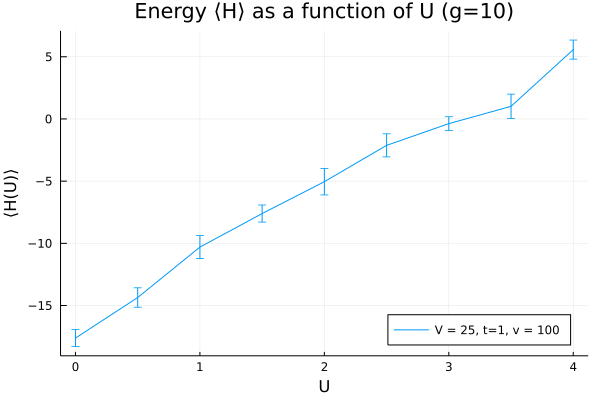

In [892]:

x = collect(0:0.5:4)

p_6 = plot(x,averages_P5, title = "Energy ⟨Η⟩ as a function of U (g=10)", label = "V = 25, t=1, v = 100", yerror = error_P5, markerstrokecolor=:auto, legend=:bottomright )
     # plot!(x,averages_0, title = "Energy ⟨Η⟩ as a function of U (g=10)", label = "V = 15, t=1, v = 100", yerror = error_0, markerstrokecolor=:auto )
     # plot!(x,averages_N5, title = "Energy ⟨Η⟩ as a function of U (g=10)", label = "V = 5, t=1, v = 100", yerror = error_N5, markerstrokecolor=:auto )
       
        xlabel!(p_6, "U")
        ylabel!(p_6, "⟨Η(U)⟩")
#savefig("Q2-E(U).png")

In [151]:
using Plots
x = collect(0:0.1:1)
y = [MC_pietro(a,10,1,2,v,100) for v in x]

plot(x,y)

LoadError: [91mInterruptException:[39m

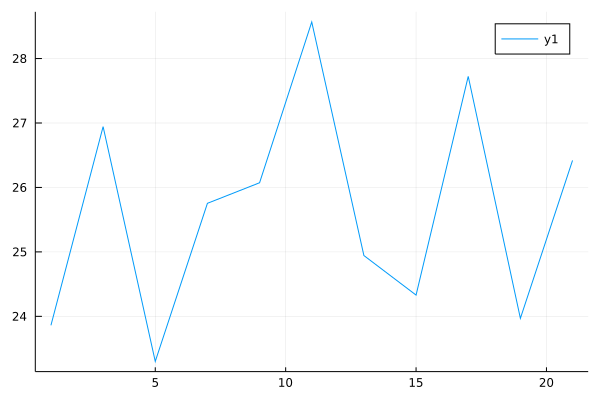

In [127]:
using Plots
x = collect(1:2:21)
y = [MC_pietro(a,10,2,v,5,100) for v in x]

plot(x,y)

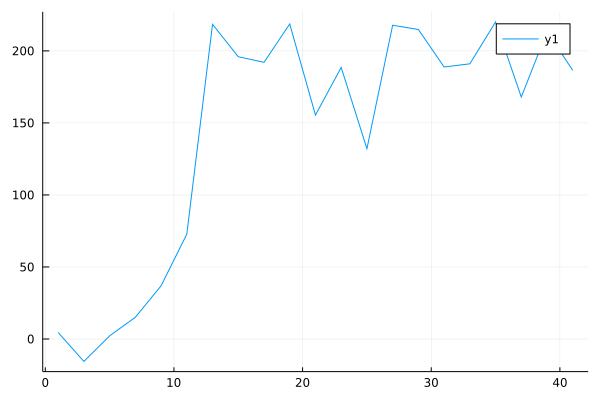

In [107]:
using Plots
x = collect(1:2:41)
y = [MC_pietro(a,10,v,30,5,100) for v in x]

plot(x,y)

In [275]:
import Random
using Statistics


function MC_pietro(q0, g, v, nsteps = 1000)
    #Random.seed!(1234)
    state_L = q0
    sumA=0
    sumB=0
    accepted_moves = 0
    
    Suma_A = []
    Suma_B = []
    
    state_new_L = zeros(length(state_L))
    
    for istep = 1:nsteps
        for j = 1:Ne
            state_2L = extendedstate(state_L)
            state_new_L = move_L(state_L)
            state_new_2L = extendedstate(state_new_L)
            acc =  (ratio_det(state_2L,state_new_2L) * (Jastrow(state_new_L,g,v)/Jastrow(state_L,g,v)))^2       #acceptance 

            acc = min(1,acc)

            if acc>rand()        #metropolis rule
                #print(acc,"\n")
                accepted_moves += 1
                state_L = copy(state_new_L)
            end
        end
            n_newA= nA(state_new_L)
            sumA+=n_newA
            push!(Suma_A,n_newA)
                #push!(Suma_A,n_newA)

            n_newB= nB(state_new_L)
            sumB+=n_newB
            push!(Suma_B,n_newB)
                #push!(Suma_B,n_newB)
    end
    return mean(Suma_A), mean(Suma_B), std(Suma_A), std(Suma_B) 
end 

MC_pietro (generic function with 4 methods)

In [225]:

MC_pietro(a, 10, 2, 1000)

(0.5403858948769118, 0.4596141051230881, 0.1468754033888848, 0.1468754033888848)

In [280]:
x = collect(2:8)
y = [MC_pietro(a, 10, v, 1000) for v in x]

7-element Array{NTuple{4,Float64},1}:
 (0.44403333333333306, 0.5559666666666672, 0.17825249119516942, 0.17825249119516956)
 (0.6149999999999987, 0.38500000000000206, 0.2143539462686602, 0.21435394626865992)
 (0.2090999999999994, 0.7909000000000066, 0.15701613384780205, 0.15701613384780086)
 (0.04996666666666633, 0.9500333333333405, 0.08576854914127488, 0.08576854914127617)
 (0.8209333333333413, 0.17906666666666596, 0.18095759812449166, 0.18095759812449286)
 (0.6222999999999984, 0.37770000000000814, 0.24365930648225428, 0.24365930648225534)
 (0.1590666666666651, 0.8409333333333371, 0.23937786862241303, 0.2393778686224143)

In [281]:
averages_a = []
averages_b = []
std_a = []
std_b = []

for i in 1:length(x)
    push!(averages_a, y[i][1])
    push!(averages_b, y[i][2])
    push!(std_a, y[i][3])
    push!(std_b, y[i][4])
    
end

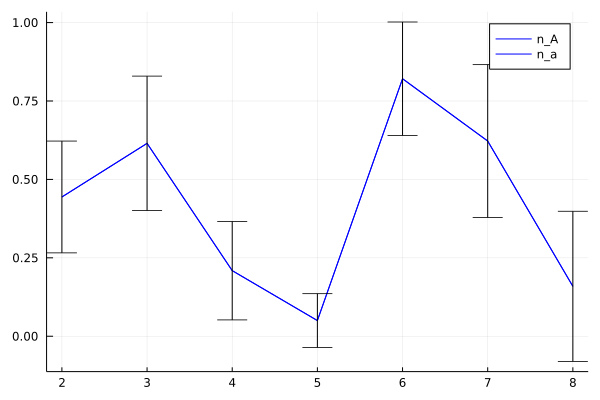

In [282]:


f = plot(x, averages_a, markersize = 15,color = :blue, label = "n_A")

lowerrors_a = -std_a 
higherrors_a = std_a
lowerrors_b = -std_b 
higherrors_b = std_b

plot!(x, averages_a, markersize = 15,color = :blue, label = "n_a", yerror=higherrors_a)


f
#savefig(f,"av_el.png")


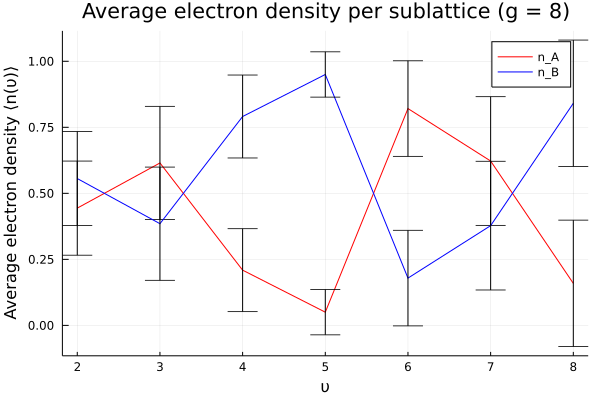

┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 1:7.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `linecolor` does not match data indices 1:7.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `fillcolor` does not match data indices 1:7.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `markercolor` does not match data indices 1:7.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Warning: Indices Base.OneTo(1) of attribute `seriescolor` does not match data indices 2:21.
└ @ Plots /Users/dianal.monroy/.julia/packages/Plots/SVksJ/src/utils.jl:102
┌ Info: Data contains NaNs or missing values, and indices of `seriescolor` vector do not match data indices.
│ If you intend elements of `seriescolor` to appl

In [290]:
p_6 = plot(x, averages_a, markersize = 15, color = [:red], label = "n_A", title = "Average electron density per sublattice (g = 8)", yerror = higherrors_a)
      plot!(x, averages_b, markersize = 15, color = [:blue], label = "n_B", title = "Average electron density per sublattice (g = 8)", yerror= higherrors_b)
        xlabel!(p_6, "υ")
        ylabel!(p_6, "Average electron density ⟨n(υ)⟩")
#savefig("Q2-1.png")